<a href="https://colab.research.google.com/github/AbelAbeb/RL-PPO-paper-presentation/blob/main/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.1 MB/s eta 0:00:00


In [ ]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()

    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy

        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])

        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)

        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break

    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)

In [ ]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)

    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)

    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals

    for _ in range(num_epochs):
        V = value_net(states).to(device)

        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)

        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)

        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k

        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent

        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()

        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()

    return policy_net, value_net

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is 26.55 with std of 14.368281038454114.
Episode: 50
The avg. test reward for episode 50 is 41.75 with std of 22.67790775181873.
Episode: 100
The avg. test reward for episode 100 is 148.7 with std of 31.4596567050564.
Episode: 150
The avg. test reward for episode 150 is 160.1 with std of 24.297942299709252.
Episode: 200
The avg. test reward for episode 200 is 128.45 with std of 10.495117912629661.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 200.0 with std of 0.0.
Episode: 350
The avg. test reward for episode 350 is 193.2 with std of 17.07219962395004.
Episode: 400
The avg. test reward for episode 400 is 172.0 with std of 46.612230154756595.
Episode: 450
The avg. test reward for episode 450 is 173.45 with std of 11.909974811056488.
Episode: 500
The avg. test reward for episode 500 is 170.75 with std of 35.849511851627774.
Episode: 550
The avg. test reward fo

 20%|██        | 1/5 [02:28<09:54, 148.63s/it]

Episode: 0
The avg. test reward for episode 0 is 19.65 with std of 9.93617129481975.
Episode: 50
The avg. test reward for episode 50 is 16.25 with std of 7.006247212309883.
Episode: 100
The avg. test reward for episode 100 is 80.75 with std of 40.861809798392436.
Episode: 150
The avg. test reward for episode 150 is 192.45 with std of 19.655724357041642.
Episode: 200
The avg. test reward for episode 200 is 131.95 with std of 25.844680303691124.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 200.0 with std of 0.0.
Episode: 350
The avg. test reward for episode 350 is 200.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 178.1 with std of 38.795489428540535.
Episode: 500
The avg. test reward for episode 500 is 195.0 with std of 6.565059024867941.
Episode: 550
The avg. test reward for episode 550 is 183.7 with std

 40%|████      | 2/5 [04:42<06:59, 139.93s/it]

Episode: 0
The avg. test reward for episode 0 is 21.6 with std of 10.744300814850634.
Episode: 50
The avg. test reward for episode 50 is 42.7 with std of 13.248018719793537.
Episode: 100
The avg. test reward for episode 100 is 22.25 with std of 4.060480267160524.
Episode: 150
The avg. test reward for episode 150 is 26.5 with std of 4.8425200051213.
Episode: 200
The avg. test reward for episode 200 is 23.8 with std of 3.8678159211627436.
Episode: 250
The avg. test reward for episode 250 is 31.45 with std of 5.324237034543072.
Episode: 300
The avg. test reward for episode 300 is 90.05 with std of 5.5988838173335935.
Episode: 350
The avg. test reward for episode 350 is 111.6 with std of 5.544366510251645.
Episode: 400
The avg. test reward for episode 400 is 123.65 with std of 8.804970187343056.
Episode: 450
The avg. test reward for episode 450 is 178.35 with std of 14.371064678721615.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test re

 60%|██████    | 3/5 [06:35<04:15, 127.65s/it]

Episode: 0
The avg. test reward for episode 0 is 21.9 with std of 11.040380428228007.
Episode: 50
The avg. test reward for episode 50 is 9.55 with std of 0.9205976319760983.
Episode: 100
The avg. test reward for episode 100 is 9.35 with std of 0.7262919523166976.
Episode: 150
The avg. test reward for episode 150 is 9.4 with std of 0.4898979485566356.
Episode: 200
The avg. test reward for episode 200 is 9.35 with std of 0.7262919523166976.
Episode: 250
The avg. test reward for episode 250 is 9.3 with std of 0.714142842854285.
Episode: 300
The avg. test reward for episode 300 is 9.05 with std of 0.6689544080129826.
Episode: 350
The avg. test reward for episode 350 is 9.3 with std of 0.7810249675906654.
Episode: 400
The avg. test reward for episode 400 is 9.5 with std of 1.02469507659596.
Episode: 450
The avg. test reward for episode 450 is 9.1 with std of 0.7681145747868608.
Episode: 500
The avg. test reward for episode 500 is 9.5 with std of 0.5.
Episode: 550
The avg. test reward for ep

 80%|████████  | 4/5 [07:40<01:42, 102.79s/it]

Episode: 0
The avg. test reward for episode 0 is 22.4 with std of 14.94456422917711.
Episode: 50
The avg. test reward for episode 50 is 32.6 with std of 11.39912277326637.
Episode: 100
The avg. test reward for episode 100 is 107.8 with std of 22.053571139386925.
Episode: 150
The avg. test reward for episode 150 is 168.8 with std of 18.717905865774622.
Episode: 200
The avg. test reward for episode 200 is 183.0 with std of 15.247950681976906.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 200.0 with std of 0.0.
Episode: 350
The avg. test reward for episode 350 is 193.65 with std of 16.73103403857634.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 189.9 with std of 21.360945671950017.
Episode: 550
The avg. test reward for episode 550 is 200.0 with std o

100%|██████████| 5/5 [09:56<00:00, 119.38s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

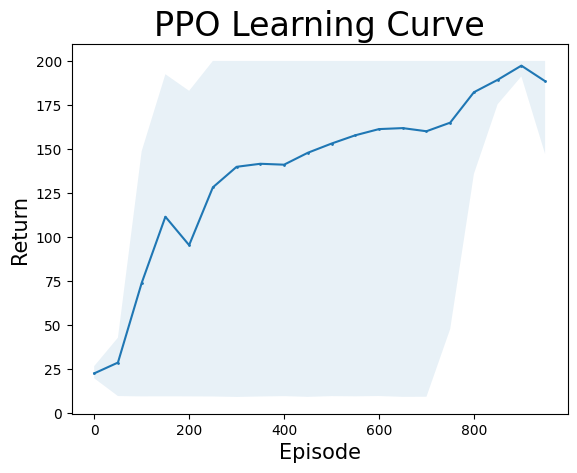

In [ ]:
# Define parameter values
env_name = 'CartPole-v0'
num_train_ite = 1000
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4

policy_lr = 5e-4 # policy network's learning rate
baseline_lr = 1e-4 # value network's learning rate

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 20.35 with std of 7.938986081358248.
Episode: 50
The avg. test reward for episode 50 is 81.7 with std of 16.825872934264066.
Episode: 100
The avg. test reward for episode 100 is 148.55 with std of 47.22973110234696.
Episode: 150
The avg. test reward for episode 150 is 186.45 with std of 26.94712415082545.
Episode: 200
The avg. test reward for episode 200 is 200.0 with std of 0.0.
Episode: 250
The avg. test reward for episode 250 is 186.25 with std of 30.64453458612155.
Episode: 300
The avg. test reward for episode 300 is 167.5 with std of 50.13531689338365.
Episode: 350
The avg. test reward for episode 350 is 191.6 with std of 21.069883720609376.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 182.05 with std of 52.56755177864002.
Episode: 500
The avg. test reward for episode 500 is 122.95 with std of 52.08596260030143.
Episode: 550
The avg. test reward for 

 20%|██        | 1/5 [02:36<10:26, 156.64s/it]

Episode: 0
The avg. test reward for episode 0 is 18.65 with std of 8.302258728803867.
Episode: 50
The avg. test reward for episode 50 is 148.75 with std of 51.51201316197999.
Episode: 100
The avg. test reward for episode 100 is 193.55 with std of 19.923541351878185.
Episode: 150
The avg. test reward for episode 150 is 141.85 with std of 33.88698127600037.
Episode: 200
The avg. test reward for episode 200 is 142.4 with std of 16.150541786577936.
Episode: 250
The avg. test reward for episode 250 is 192.4 with std of 22.90720410700529.
Episode: 300
The avg. test reward for episode 300 is 153.45 with std of 26.826246476165835.
Episode: 350
The avg. test reward for episode 350 is 145.25 with std of 30.716241632074716.
Episode: 400
The avg. test reward for episode 400 is 199.9 with std of 0.43588989435406733.
Episode: 450
The avg. test reward for episode 450 is 176.55 with std of 50.350248261552785.
Episode: 500
The avg. test reward for episode 500 is 197.1 with std of 12.640806936267952.
Ep

 40%|████      | 2/5 [05:12<07:48, 156.25s/it]

Episode: 0
The avg. test reward for episode 0 is 22.4 with std of 8.558037158133867.
Episode: 50
The avg. test reward for episode 50 is 120.0 with std of 40.577087130546964.
Episode: 100
The avg. test reward for episode 100 is 170.15 with std of 40.73607123913645.
Episode: 150
The avg. test reward for episode 150 is 155.9 with std of 48.840454543339376.
Episode: 200
The avg. test reward for episode 200 is 124.6 with std of 23.62287027437606.
Episode: 250
The avg. test reward for episode 250 is 190.2 with std of 27.451047338853943.
Episode: 300
The avg. test reward for episode 300 is 141.75 with std of 23.708384592797543.
Episode: 350
The avg. test reward for episode 350 is 196.95 with std of 8.511609718496262.
Episode: 400
The avg. test reward for episode 400 is 190.05 with std of 16.974907952622303.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward fo

 60%|██████    | 3/5 [07:43<05:07, 153.84s/it]

Episode: 0
The avg. test reward for episode 0 is 21.7 with std of 7.156116265125938.
Episode: 50
The avg. test reward for episode 50 is 73.05 with std of 26.004759179811682.
Episode: 100
The avg. test reward for episode 100 is 176.7 with std of 27.702165980298364.
Episode: 150
The avg. test reward for episode 150 is 182.3 with std of 14.792227688891217.
Episode: 200
The avg. test reward for episode 200 is 198.1 with std of 8.28190799272728.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 200.0 with std of 0.0.
Episode: 350
The avg. test reward for episode 350 is 198.9 with std of 3.9736632972611052.
Episode: 400
The avg. test reward for episode 400 is 197.3 with std of 11.100000000000001.
Episode: 450
The avg. test reward for episode 450 is 196.5 with std of 15.256146302392358.
Episode: 500
The avg. test reward for episode 500 is 195.55 with std of 13.358424308278279.
Episode: 550
The avg. test reward for 

 80%|████████  | 4/5 [10:15<02:33, 153.00s/it]

Episode: 0
The avg. test reward for episode 0 is 26.4 with std of 14.558159224297555.
Episode: 50
The avg. test reward for episode 50 is 135.35 with std of 57.79210586230614.
Episode: 100
The avg. test reward for episode 100 is 170.85 with std of 27.44316854883925.
Episode: 150
The avg. test reward for episode 150 is 199.45 with std of 2.3973944189473704.
Episode: 200
The avg. test reward for episode 200 is 178.6 with std of 39.09398930782071.
Episode: 250
The avg. test reward for episode 250 is 181.9 with std of 23.500851048419502.
Episode: 300
The avg. test reward for episode 300 is 198.05 with std of 8.499852939904315.
Episode: 350
The avg. test reward for episode 350 is 194.65 with std of 19.76935760210736.
Episode: 400
The avg. test reward for episode 400 is 187.65 with std of 34.86728409268493.
Episode: 450
The avg. test reward for episode 450 is 153.35 with std of 22.138823365301054.
Episode: 500
The avg. test reward for episode 500 is 86.0 with std of 30.29521414349138.
Episode

100%|██████████| 5/5 [12:35<00:00, 151.14s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

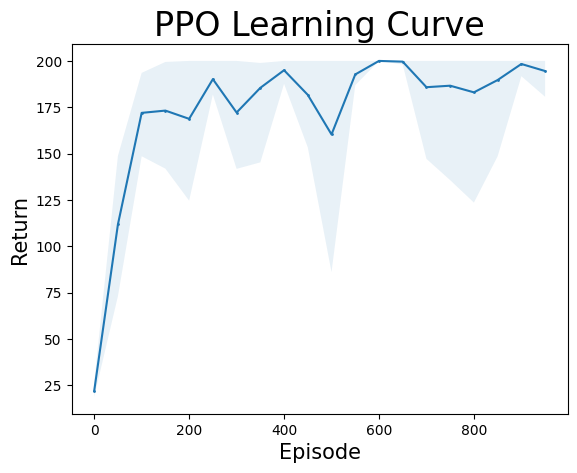

In [ ]:
def compute_Gs_per_episode(batch_rews, gamma):
    # The rewards-to-go (rtg) per episode per batch to return
    batch_rtgs = []

    # Iterate through each episode backwards to maintain same order in batch_rtgs
    for ep_rews in reversed(batch_rews):
        discounted_reward = 0 # Discounted reward so far

        for rew in reversed(ep_rews):
            discounted_reward = rew + discounted_reward * gamma
            batch_rtgs.insert(0, discounted_reward)

    # Convert the rewards-to-go into a tensor
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

    return batch_rtgs


def generate_multiple_episodes(env, policy_net, max_batch_size=500):
    """
    Generates episodes by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    i = 0

    while i < max_batch_size:
        state, _ = env.reset()
        reward_per_epi = []
        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
            # action = np.argmax(probs.detach().numpy()) # greedy

            # compute the log_prob to use this in parameter update
            log_prob = torch.log(probs.squeeze(0)[action])

            # append values
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)

            # take a selected action
            state, reward, terminated, truncated, _ = env.step(action)
            reward_per_epi.append(reward)

            i += 1

            if terminated | truncated:
                break
        rewards.append(reward_per_epi)

    return states, actions, rewards, log_probs


def train_PPO_multi_epi(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, max_batch_size=100, entropy_coef=0.1, normalize_ad=True, add_entropy=True):
    """
    Trains the policy network using PPO with some modeling techniques
    """

    # Generate episodes with the current policy network
    states, actions, rewards, log_probs = generate_multiple_episodes(env, policy_net, max_batch_size=max_batch_size)
    T = len(states)

    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step in each episode
    Gs = compute_Gs_per_episode(rewards, gamma).view(-1,1)

    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
    if normalize_ad:
        A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # Normalize advantages

    for _ in range(num_epochs):
        V = value_net(states).to(device)

        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)

        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)

        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k

        # Caluculate entropy
        entropy = 0
        if add_entropy:
            entropy = torch.distributions.Categorical(probs).entropy()
            entropy = torch.tensor([[e] for e in entropy])

        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2) - entropy_coef * entropy).mean() # Need negative sign to run Gradient Ascent

        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()

        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()

    return policy_net, value_net

# Define parameter values
returns = np.zeros((num_seeds, eval_epi_index))
max_batch_size = 100
entropy_coef = 0.1
normalize_ad = True
add_entropy = True

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO_multi_epi(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma, max_batch_size=max_batch_size, entropy_coef=entropy_coef, normalize_ad=normalize_ad, add_entropy=add_entropy)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)